## 데이터 학습 및 추후 전처리

In [3]:
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sentence_transformers import SentenceTransformer, InputExample, losses
from torch.utils.data import DataLoader
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import accuracy_score, f1_score


# Load the CSV file
file_path = '../data/updated_비식별된_해외기업별_영문_텍스트데이터.csv'
df3 = pd.read_csv(file_path)
df3

,ID,CODE,DSC,Mapped_Values,Corresponding_Values,Joined_Corresponding_Values,hs6_text,joined_hs6_text
0,1,4520,"automotive repair shops, nec specialized auto...",NaN,NaN,NaN,[],NaN
1,2,149,"general farms, primarily animals, nsk derives...","['010614', '041000', '010620', '030760', '0106...","[('0106141000', 'Pure-bred breeding animals'),...",Pure-bred breeding animals [CLS] Living Animal...,"['Mammals; live, rabbits and hares', 'Animal p...","Mammals; live, rabbits and hares [CLS] Animal ..."
2,3,4630,fish and seafoods the wholesale distribution ...,NaN,NaN,NaN,[],NaN
3,4,4510,"new and used car dealers, nsk manufactures a ...",NaN,NaN,NaN,[],NaN
4,4,2930,"automotive stampings, nsk manufacturing autom...","['851220', '840991', '940110', '870821', '8511...","[('85122010', 'Lighting equipment'), ('8512201...",Lighting equipment [CLS] Of light-emitting dio...,['Lighting or visual signalling equipment; ele...,Lighting or visual signalling equipment; elect...
...,...,...,...,...,...,...,...,...
9995,10641,1811,"commercial printing, nec commercial or job pr...",['491199'],"[('4911990000', 'Printed')]",Printed,['Printed matter; n.e.c. in heading no. 4911'],Printed matter; n.e.c. in heading no. 4911
9996,10642,1104,"bottled and canned soft drinks, nsk manufactu...","['220210', '220299', '220110']","[('2202101000', 'Coloured'), ('2202109000', 'D...",Coloured [CLS] Drinks [CLS] Beverage based on ...,"['Waters; including mineral and aerated, conta...","Waters; including mineral and aerated, contain..."
9997,10643,4659,"professional equipment, nec, nsk the wholesal...",NaN,NaN,NaN,[],NaN
9998,10644,2410,"blast furnaces and steel mills, nsk manufactu...","['720610', '722240', '722230', '730511', '7218...","[('7206100000', 'Ingots'), ('7222400000', 'Ang...","Ingots [CLS] Angles, shapes and sections [CLS]...",['Iron or non-alloy steel; ingots (excluding i...,Iron or non-alloy steel; ingots (excluding iro...


hscode_7000은 매핑되지 않은 데이터(약 7000개)에 대해 HSCODE 6자리를 매핑한 데이터입니다.
-> EDA2 파일

In [2]:
from ast import literal_eval

hscode_7000 = pd.read_csv("..\data\hscode_7000.csv")
# Ensure the Corresponding_Values column is evaluated as lists
def safe_literal_eval(val):
    try:
        return literal_eval(val)
    except (ValueError, SyntaxError):
        return []

hscode_7000['hscode'] = hscode_7000['hscode'].apply(safe_literal_eval)
hscode_7000

<>:3: SyntaxWarning: invalid escape sequence '\d'
<>:3: SyntaxWarning: invalid escape sequence '\d'
C:\Users\DILAB\AppData\Local\Temp\ipykernel_29364\3469426634.py:3: SyntaxWarning: invalid escape sequence '\d'
  hscode_7000 = pd.read_csv("..\data\hscode_7000.csv")


,ID,CODE,DSC,hscode
0,1,4520,"automotive repair shops, nec specialized auto...","[960400, 911190, 860800, 870530, 970500, 99999..."
1,2,149,"general farms, primarily animals, nsk derives...",[]
2,3,4630,fish and seafoods the wholesale distribution ...,"[960400, 999999, 970500, 961800, 010690]"
3,4,4510,"new and used car dealers, nsk manufactures a ...","[960400, 870530, 911190, 870390, 860800, 99999..."
4,4,2930,"automotive stampings, nsk manufacturing autom...",[]
...,...,...,...,...
9995,10641,1811,"commercial printing, nec commercial or job pr...",[]
9996,10642,1104,"bottled and canned soft drinks, nsk manufactu...",[]
9997,10643,4659,"professional equipment, nec, nsk the wholesal...","[960400, 911190, 860800, 999999, 911220, 97050..."
9998,10644,2410,"blast furnaces and steel mills, nsk manufactu...",[]


### 외부 데이터 활용하여 영문명 CLS 토큰으로 합침
외부 데이터를 활용해 매핑된 HSCODE 6자리에 대응되는 영문 데이터를 가져오고,

CLS 토큰으로 이어붙여 하나의 문장으로 만들어줍니다.

In [4]:
import requests

url = 'https://comtradeapi.un.org/files/v1/app/reference/H5.json'
data = requests.get(url).json()

hs6_list = [item['text'] for item in data['results'] if len(item['id']) == 6]
hs6_info = [(item.split(" - ", 1)[0], item.split(" - ", 1)[1]) for item in hs6_list]

# hs6_dict 생성
hs6_dict = {code: text for code, text in hs6_info}

# 새로운 컬럼에 대응되는 텍스트 리스트 추가
def get_text_list(mapped_values):
    if isinstance(mapped_values, list) and mapped_values:  # 리스트이고 비어 있지 않은 경우에만 처리
        texts = [hs6_dict[code] for code in mapped_values if code in hs6_dict]
        return [text for text in texts if text is not None]
    return []

hscode_7000['hs6_text'] = hscode_7000['hscode'].apply(get_text_list)


# Create a new column with the CLS token joined string of the second element in the tuples
def create_joined_string(corresponding_values):
    if corresponding_values:
        return ' [CLS] '.join(corresponding_values)
    else:
        return ''

hscode_7000['joined_hs6_text'] = hscode_7000['hs6_text'].apply(create_joined_string)


In [5]:
hscode_7000

,ID,CODE,DSC,hscode,hs6_text,joined_hs6_text
0,1,4520,"automotive repair shops, nec specialized auto...","[960400, 911190, 860800, 870530, 970500, 99999...","[Hand sieves and hand riddles, Watch cases and...",Hand sieves and hand riddles [CLS] Watch cases...
1,2,149,"general farms, primarily animals, nsk derives...",[],[],
2,3,4630,fish and seafoods the wholesale distribution ...,"[960400, 999999, 970500, 961800, 010690]","[Hand sieves and hand riddles, Commodities not...",Hand sieves and hand riddles [CLS] Commodities...
3,4,4510,"new and used car dealers, nsk manufactures a ...","[960400, 870530, 911190, 870390, 860800, 99999...","[Hand sieves and hand riddles, Vehicles; fire ...",Hand sieves and hand riddles [CLS] Vehicles; f...
4,4,2930,"automotive stampings, nsk manufacturing autom...",[],[],
...,...,...,...,...,...,...
9995,10641,1811,"commercial printing, nec commercial or job pr...",[],[],
9996,10642,1104,"bottled and canned soft drinks, nsk manufactu...",[],[],
9997,10643,4659,"professional equipment, nec, nsk the wholesal...","[960400, 911190, 860800, 999999, 911220, 97050...","[Hand sieves and hand riddles, Watch cases and...",Hand sieves and hand riddles [CLS] Watch cases...
9998,10644,2410,"blast furnaces and steel mills, nsk manufactu...",[],[],


3000개와 7000개 데이터를 합쳐줍니다.

In [6]:
# df3의 'joined_hs6_text' 컬럼의 NaN 값을 같은 인덱스의 hscode_7000의 'joined_hs6_text' 값으로 채웁니다.
df3['joined_hs6_text'] = df3['joined_hs6_text'].combine_first(hscode_7000['joined_hs6_text'])

In [17]:
df3['hs6_text'].isna().sum()

0

### 학습 데이터 설정
라벨이 없어 비지도 학습을 이용해야 하는 데이터지만 전처리를 통해 매핑된 데이터를 이용해 지도 학습 중 하나인 대조 학습을 진행했습니다.

(DSC / HSCODE 6자리 영문 데이터를 이어붙인 문장) 학습

positive example: 이미 매핑된 문장 2개 -> label: 1, 
negative example: 임의로 다르게 매핑한 문장 2개 -> label: 0

이와 같이 모델이 매핑된 문장은 유사하고, 매핑되지 않은 문장 중 임의로 추출한 문장은 유사하지 않다는 것을 학습시키는 방법입니다.

In [18]:
# Create positive examples
positive_examples = []
for idx, row in df3.iterrows():
    positive_examples.append(InputExample(texts=[str(row['DSC']), str(row['joined_hs6_text'])], label=1.0))

# Create negative examples by pairing each DSC with a random Joined_Corresponding_Values
negative_examples = []
for idx, row in df3.iterrows():
    random_idx = np.random.choice(df3.index)
    random_row = df3.loc[random_idx]
    negative_examples.append(InputExample(texts=[str(row['DSC']), str(random_row['joined_hs6_text'])], label=0.0))

# Combine positive and negative examples
examples = positive_examples + negative_examples

# 일부 train_examples 항목 출력
for example in examples[:5]:  # 처음 5개 예제만 출력
    print(f"Texts: {example.texts}, Label: {example.label}")

Texts: ['industrial organic chemicals, nec  the wholesale distribution of chemicals and allied products, not elsewhere classified, such as acids, industrial and heavy chemicals, dyestuffs, industrial salts, rosin, and turpentine. chemical wholesale industrial organic chemicals, nec other chemical and allied products merchant wholesalers wholesale of chemical products wholesale of waste and scrap and other products n.e.c. wholesale of chemical productsindustrial and agricultural chemical product wholesaling', "Nitrogen [CLS] Arsenic [CLS] Oxygen [CLS] Iodine [CLS] Hydrogen [CLS] Phosphorus [CLS] Hand sieves and hand riddles [CLS] Chlorine [CLS] Mercury [CLS] Commodities not specified according to kind [CLS] Antimony; waste and scrap [CLS] Nickel; waste and scrap [CLS] Beryllium; waste and scrap [CLS] Railway or tramway track fixtures and fittings; mechanical (including electro-mechanical) signalling, safety or traffic control equipment for railways, tramways, roads, inland waterways, pa

### 모델 불러오기, dataloader 생성, loss 함수 지정
사전학습된 Sentence-BERT (SBERT) 모델을 사용했습니다. 문장 쌍에 대해 사전학습된 모델이라 문장의 유사도를 학습하는 데에 BERT보다 좋을 것 같다 판단되어 사용했습니다.

In [21]:
from torch.utils.data import DataLoader
from sentence_transformers import SentenceTransformer, losses, SentencesDataset, InputExample
import torch

# Model definition
model = SentenceTransformer('bert-base-uncased')

all_dataset = SentencesDataset(examples, model)

# DataLoader에서 collate_fn을 사용하여 InputExample을 텐서로 변환
def collate_fn(batch):
    texts1 = [example.texts[0] for example in batch]
    texts2 = [example.texts[1] for example in batch]
    labels = torch.tensor([example.label for example in batch], dtype=torch.float32)
    return texts1, texts2, labels


all_dataloader = DataLoader(all_dataset, shuffle=False, batch_size=16, collate_fn=collate_fn)

# Loss function: Contrastive Loss
train_loss = losses.ContrastiveLoss(model=model)

No sentence-transformers model found with name bert-base-uncased. Creating a new one with mean pooling.


### 학습
epoch 3, ContrastiveLoss로 학습했습니다.

In [22]:

# Check if GPU is available and set the device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

# Training with validation
num_epochs = 3
for epoch in range(num_epochs):
    model.fit(train_objectives=[(all_dataloader, train_loss)], epochs=1, warmup_steps=100, show_progress_bar=True)

  0%|          | 0/1250 [00:00<?, ?it/s]

{'loss': 0.01, 'grad_norm': 0.20751726627349854, 'learning_rate': 1.3043478260869566e-05, 'epoch': 0.4}
{'loss': 0.004, 'grad_norm': 0.05591661110520363, 'learning_rate': 4.347826086956522e-06, 'epoch': 0.8}
{'train_runtime': 5715.6043, 'train_samples_per_second': 3.499, 'train_steps_per_second': 0.219, 'train_loss': 0.006249886751174927, 'epoch': 1.0}


  0%|          | 0/1250 [00:00<?, ?it/s]

{'loss': 0.0029, 'grad_norm': 0.17654474079608917, 'learning_rate': 1.3043478260869566e-05, 'epoch': 0.4}
{'loss': 0.0024, 'grad_norm': 0.08524028211832047, 'learning_rate': 4.347826086956522e-06, 'epoch': 0.8}
{'train_runtime': 5136.2908, 'train_samples_per_second': 3.894, 'train_steps_per_second': 0.243, 'train_loss': 0.0025553474426269532, 'epoch': 1.0}


  0%|          | 0/1250 [00:00<?, ?it/s]

{'loss': 0.0018, 'grad_norm': 0.021170733496546745, 'learning_rate': 1.3043478260869566e-05, 'epoch': 0.4}
{'loss': 0.0016, 'grad_norm': 0.11508581787347794, 'learning_rate': 4.347826086956522e-06, 'epoch': 0.8}
{'train_runtime': 5429.0566, 'train_samples_per_second': 3.684, 'train_steps_per_second': 0.23, 'train_loss': 0.0017121512413024902, 'epoch': 1.0}


In [23]:
# 모델 저장
model_save_path = 'model/ISIC_HSCODE6_BERT_10000'
model.save(model_save_path)
print(f"Model saved to {model_save_path}")


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

Model saved to model/ISIC_HSCODE6_BERT_10000


모델 성능 확인

In [24]:
from sklearn.metrics.pairwise import cosine_similarity

# 테스트할 문장 쌍
test_sentence_pairs = [
    (df3['DSC'][1], df3['Joined_Corresponding_Values'][1]),
    (df3['DSC'][4], df3['Joined_Corresponding_Values'][4]),
    (df3['DSC'][7], df3['Joined_Corresponding_Values'][7]),
    (df3['DSC'][1], df3['Joined_Corresponding_Values'][7]),
    (df3['DSC'][4], df3['Joined_Corresponding_Values'][1]),
    (df3['DSC'][7], df3['Joined_Corresponding_Values'][4])
]

# 문장 임베딩 계산
for sentence1, sentence2 in test_sentence_pairs:
    embedding1 = model.encode(sentence1)
    embedding2 = model.encode(sentence2)
    
    # 코사인 유사도 계산
    similarity = cosine_similarity([embedding1], [embedding2])[0][0]
    print(f"Sentence 1: {sentence1}")
    print(f"Sentence 2: {sentence2}")
    print(f"Cosine Similarity: {similarity:.4f}\n")


Sentence 1: general farms, primarily animals, nsk  derives 50 percent or more of its total value  of sales of agricultural products from livestock and animal specialties and their products, but less than 50 percent from products of any single three-digit industry group. crop and animal production general farms, primarily animals all other animal production mixed farming raising of other animals mixed farmingother livestock farming not elsewhere classified
Sentence 2: Pure-bred breeding animals [CLS] Living Animals [CLS] Snakes [CLS] Fresh-water tortoises [CLS] Turtles [CLS] Living Animals [CLS] Snails, other than sea snails [CLS] Bees [CLS] Silk-worm cocoons suitable for reeling. [CLS] Primates [CLS] Birds of prey [CLS] Ostriches; emus (Dromaius novaehollandiae) [CLS] Dogs [CLS] Deer [CLS] Bears [CLS] Fox [CLS] Pure-bred breeding animals [CLS] Living Animals [CLS] Mink [CLS] Pure-bred breeding animals [CLS] Living Animals [CLS] Living Animals [CLS] Living Animals [CLS] Natural honey.
C

7000개 데이터에 대해 HSCODE 6자리로 시작하는 HSCODE 10자리 및 영문데이터를 가져옵니다.

In [34]:
from tqdm import tqdm

file_path1 = '../data/updated_관세청_HS부호_240101.csv'


df1 = pd.read_csv(file_path1, converters={'HS부호':str, '성질통합분류코드':str})


def find_corresponding_values(mapped_values):
    result = []
    if isinstance(mapped_values, list):
        for val in mapped_values:
            matched_rows = df1[df1['HS부호'].str[:len(val)] == val]
            for _, matched_row in matched_rows.iterrows():
                result.append((matched_row['HS부호'], matched_row['영문품목명']))
        return result
    else:
        return None  # If mapped_values is not a list or is null, return None

# Apply the function to df3 with tqdm progress bar
results = []
for index, row in tqdm(hscode_7000.iterrows(), total=len(hscode_7000)):
    results.append(find_corresponding_values(row.hscode))

hscode_7000['Corresponding_Values'] = results

100%|██████████| 10000/10000 [02:58<00:00, 55.93it/s]


In [80]:
hscode_7000

,ID,CODE,DSC,hscode,hs6_text,joined_hs6_text,Corresponding_Values
0,1,4520,"automotive repair shops, nec specialized auto...","['960400', '911190', '860800', '870530', '9705...","['Hand sieves and hand riddles', 'Watch cases ...",Hand sieves and hand riddles [CLS] Watch cases...,"[('9604000000', 'Hand sieves and hand riddles...."
1,2,149,"general farms, primarily animals, nsk derives...",[],[],NaN,[]
2,3,4630,fish and seafoods the wholesale distribution ...,"['960400', '999999', '970500', '961800', '0106...","['Hand sieves and hand riddles', 'Commodities ...",Hand sieves and hand riddles [CLS] Commodities...,"[('9604000000', 'Hand sieves and hand riddles...."
3,4,4510,"new and used car dealers, nsk manufactures a ...","['960400', '870530', '911190', '870390', '8608...","['Hand sieves and hand riddles', 'Vehicles; fi...",Hand sieves and hand riddles [CLS] Vehicles; f...,"[('9604000000', 'Hand sieves and hand riddles...."
4,4,2930,"automotive stampings, nsk manufacturing autom...",[],[],NaN,[]
...,...,...,...,...,...,...,...
9995,10641,1811,"commercial printing, nec commercial or job pr...",[],[],NaN,[]
9996,10642,1104,"bottled and canned soft drinks, nsk manufactu...",[],[],NaN,[]
9997,10643,4659,"professional equipment, nec, nsk the wholesal...","['960400', '911190', '860800', '999999', '9112...","['Hand sieves and hand riddles', 'Watch cases ...",Hand sieves and hand riddles [CLS] Watch cases...,"[('9604000000', 'Hand sieves and hand riddles...."
9998,10644,2410,"blast furnaces and steel mills, nsk manufactu...",[],[],NaN,[]


In [81]:
import ast

hscode_7000['Corresponding_Values'] = hscode_7000['Corresponding_Values'].apply(ast.literal_eval)

In [87]:
# 빈 리스트인 행의 'Corresponding_Values' 값을 같은 인덱스의 hscode_7000 값으로 채우기
def fill_empty_values(row, hscode_values):
    if not row['Corresponding_Values']:  # 빈 리스트인 경우
        return hscode_values
    return row['Corresponding_Values']

df3['Corresponding_Values'] = df3.apply(
    lambda row: fill_empty_values(row, hscode_7000.loc[row.name, 'Corresponding_Values']),
    axis=1
)

### 추론
학습한 모델을 토대로 DSC과 HSCODE 10자리의 영문 데이터 유사도를 계산합니다.

DSC과 각각의 단어 임베딩을 구하고 코사인 유사도를 사용해 유사도를 계산합니다.

In [102]:
def get_most_relevant_words(dsc, corresponding_values):
    # Corresponding_Values가 빈 리스트인 경우 건너뛰기
    if not corresponding_values:
        return []

    # DSC 값 임베딩
    dsc_embedding = model.encode(dsc, convert_to_tensor=True)
    
    # Corresponding_Values에 있는 각 단어 임베딩 및 유사도 계산
    relevance_info = []
    for code, word in corresponding_values:
        word_embedding = model.encode(word, convert_to_tensor=True)
        similarity = cosine_similarity(dsc_embedding.cpu().numpy().reshape(1, -1), 
                                       word_embedding.cpu().numpy().reshape(1, -1))
        relevance_info.append((code, word, similarity.item()))
    
    # 유사도 기준으로 정렬
    relevance_info.sort(key=lambda x: x[2], reverse=True)
    
    return relevance_info

relevant_words = get_most_relevant_words(df3['DSC'][4], df3['Corresponding_Values'][4])
relevant_words


[('8409912000', 'For outboard motors', 0.804646372795105),
 ('8409911000', 'For vehicles of Chapter 87', 0.7569855451583862),
 ('8511501000', 'For aircrafts', 0.7266252040863037),
 ('8511201000', 'For aircrafts', 0.7266252040863037),
 ('8511509000', 'Car parts', 0.7127067446708679),
 ('8511209000', 'Car parts', 0.7127067446708679),
 ('8708210000', 'Safety seat belts', 0.6840641498565674),
 ('9401100000', 'Seats of a kind used for aircraft', 0.6129147410392761),
 ('8708100000', 'Bumpers and parts thereof', 0.5372174978256226),
 ('8531909000', 'Electrical Mechanical Parts', 0.4278451204299927),
 ('85122020', 'Signalling equipment', 0.2716239392757416),
 ('8512201010', 'Of light-emitting diode (LED)', 0.22598257660865784),
 ('8512202010', 'Of light-emitting diode (LED)', 0.22598257660865784),
 ('8531901000', 'Of subheading 8531.10', 0.16046538949012756),
 ('8531902000', 'Of subheading 8531.20', 0.1579720377922058),
 ('8512201090', 'Lights', 0.11666889488697052),
 ('8512202090', 'Lights', 

### 상위 n개 HSCODE 10자리 걸러내기

3가지 방법 중 가장 높은 유사도의 80%에 해당하는 값보다 높을 경우 가져오는 방식으로 계산했습니다.

In [106]:
from scipy import stats
# 신뢰구간 기반으로 상위 유사한 단어 선택
# 신뢰구간 기반으로 상위 유사한 단어 선택
def get_top_relevant_words_confidence(relevance_info, confidence_level=0.95):
    if not relevance_info:
        return [], []

    similarities = [info[2] for info in relevance_info]
    mean_similarity = np.mean(similarities)
    std_dev = np.std(similarities)
    
    # 신뢰구간 계산
    h = std_dev * stats.t.ppf((1 + confidence_level) / 2, len(similarities) - 1)
    lower_bound = mean_similarity - h

    # 신뢰구간 내에 있는 단어들 선택
    top_relevant_words = [info for info in relevance_info if info[2] >= lower_bound]
    
    return top_relevant_words

top_relevants = get_top_relevant_words_confidence(relevant_words)
top_relevants

# df3['top_relevant_words_confidence'] = df3['relevance_info'].apply(get_top_relevant_words_confidence)


[('8409912000', 'For outboard motors', 0.804646372795105),
 ('8409911000', 'For vehicles of Chapter 87', 0.7569855451583862),
 ('8511501000', 'For aircrafts', 0.7266252040863037),
 ('8511201000', 'For aircrafts', 0.7266252040863037),
 ('8511509000', 'Car parts', 0.7127067446708679),
 ('8511209000', 'Car parts', 0.7127067446708679),
 ('8708210000', 'Safety seat belts', 0.6840641498565674),
 ('9401100000', 'Seats of a kind used for aircraft', 0.6129147410392761),
 ('8708100000', 'Bumpers and parts thereof', 0.5372174978256226),
 ('8531909000', 'Electrical Mechanical Parts', 0.4278451204299927),
 ('85122020', 'Signalling equipment', 0.2716239392757416),
 ('8512201010', 'Of light-emitting diode (LED)', 0.22598257660865784),
 ('8512202010', 'Of light-emitting diode (LED)', 0.22598257660865784),
 ('8531901000', 'Of subheading 8531.10', 0.16046538949012756),
 ('8531902000', 'Of subheading 8531.20', 0.1579720377922058),
 ('8512201090', 'Lights', 0.11666889488697052),
 ('8512202090', 'Lights', 

In [107]:
def get_top_percent_relevant_words(relevance_info, percent=0.5):
    if not relevance_info:
        return []

    cutoff_index = max(1, int(len(relevance_info) * percent))
    return relevance_info[:cutoff_index]

get_top_percent_relevant_words(relevant_words)

[('8409912000', 'For outboard motors', 0.804646372795105),
 ('8409911000', 'For vehicles of Chapter 87', 0.7569855451583862),
 ('8511501000', 'For aircrafts', 0.7266252040863037),
 ('8511201000', 'For aircrafts', 0.7266252040863037),
 ('8511509000', 'Car parts', 0.7127067446708679),
 ('8511209000', 'Car parts', 0.7127067446708679),
 ('8708210000', 'Safety seat belts', 0.6840641498565674),
 ('9401100000', 'Seats of a kind used for aircraft', 0.6129147410392761),
 ('8708100000', 'Bumpers and parts thereof', 0.5372174978256226)]

In [195]:
# 가장 유사한 단어들 선택 (유사도의 80% 이상)
def get_top_relevant_words(relevance_info, threshold_ratio=0.7):
    if not relevance_info:
        return []

    max_similarity = relevance_info[0][2]
    threshold = max_similarity * threshold_ratio

    top_relevant_words = [info for info in relevance_info if info[2] >= threshold]
    
    return top_relevant_words

get_top_relevant_words(relevant_words)

[('8409912000', 'For outboard motors', 0.804646372795105),
 ('8409911000', 'For vehicles of Chapter 87', 0.7569855451583862),
 ('8511501000', 'For aircrafts', 0.7266252040863037),
 ('8511201000', 'For aircrafts', 0.7266252040863037),
 ('8511509000', 'Car parts', 0.7127067446708679),
 ('8511209000', 'Car parts', 0.7127067446708679),
 ('8708210000', 'Safety seat belts', 0.6840641498565674),
 ('9401100000', 'Seats of a kind used for aircraft', 0.6129147410392761)]

In [111]:
# 새로운 컬럼에 가장 유사한 단어 셋을 추가
df3['Top_Relevant_Words'] = df3.apply(lambda row: get_top_relevant_words(get_most_relevant_words(row['DSC'], row['Corresponding_Values'])), axis=1)

In [112]:
df3

,ID,CODE,DSC,Mapped_Values,Corresponding_Values,Joined_Corresponding_Values,hs6_text,joined_hs6_text,Top_Relevant_Words
0,1,4520,"automotive repair shops, nec specialized auto...",NaN,"[(9604000000, Hand sieves and hand riddles.), ...",NaN,[],Hand sieves and hand riddles [CLS] Watch cases...,"[(8705909060, Telegraphy, radiotelegraphy and ..."
1,2,149,"general farms, primarily animals, nsk derives...","['010614', '041000', '010620', '030760', '0106...","[(0106141000, Pure-bred breeding animals), (01...",Pure-bred breeding animals [CLS] Living Animal...,"['Mammals; live, rabbits and hares', 'Animal p...","Mammals; live, rabbits and hares [CLS] Animal ...","[(0106141000, Pure-bred breeding animals, 0.93..."
2,3,4630,fish and seafoods the wholesale distribution ...,NaN,"[(9604000000, Hand sieves and hand riddles.), ...",NaN,[],Hand sieves and hand riddles [CLS] Commodities...,"[(0106903090, Living Animals, 0.85173982381820..."
3,4,4510,"new and used car dealers, nsk manufactures a ...",NaN,"[(9604000000, Hand sieves and hand riddles.), ...",NaN,[],Hand sieves and hand riddles [CLS] Vehicles; f...,"[(87049010, General motor vehicles for the tra..."
4,4,2930,"automotive stampings, nsk manufacturing autom...","['851220', '840991', '940110', '870821', '8511...","[(85122010, Lighting equipment), (8512201010, ...",Lighting equipment [CLS] Of light-emitting dio...,['Lighting or visual signalling equipment; ele...,Lighting or visual signalling equipment; elect...,"[(8409912000, For outboard motors, 0.804646372..."
...,...,...,...,...,...,...,...,...,...
9995,10641,1811,"commercial printing, nec commercial or job pr...",['491199'],"[(4911990000, Printed)]",Printed,['Printed matter; n.e.c. in heading no. 4911'],Printed matter; n.e.c. in heading no. 4911,"[(4911990000, Printed, 0.7526559829711914)]"
9996,10642,1104,"bottled and canned soft drinks, nsk manufactu...","['220210', '220299', '220110']","[(2202101000, Coloured), (2202109000, Drinks),...",Coloured [CLS] Drinks [CLS] Beverage based on ...,"['Waters; including mineral and aerated, conta...","Waters; including mineral and aerated, contain...","[(2202991000, Beverage based on ginseng, 0.880..."
9997,10643,4659,"professional equipment, nec, nsk the wholesal...",NaN,"[(9604000000, Hand sieves and hand riddles.), ...",NaN,[],Hand sieves and hand riddles [CLS] Watch cases...,"[(8608002000, Mechanical signalling, safety or..."
9998,10644,2410,"blast furnaces and steel mills, nsk manufactu...","['720610', '722240', '722230', '730511', '7218...","[(7206100000, Ingots), (7222400000, Angles, sh...","Ingots [CLS] Angles, shapes and sections [CLS]...",['Iron or non-alloy steel; ingots (excluding i...,Iron or non-alloy steel; ingots (excluding iro...,"[(73066110, Of iron or non-alloy steel, 0.9289..."


### 매핑된 HSCODE 6자리와 10자리가 대응되지 않는 경우
매핑된 6자리로 시작하지 않는 경우가 있어 확인해보니 4자리까진 대응되는 10자리가 있어 4자리를 토대로 매핑시켰습니다.

In [129]:
empty_list_rows = df3[df3['Corresponding_Values'].apply(lambda x: len(x) == 0)]
empty_list_rows

,ID,CODE,DSC,Mapped_Values,Corresponding_Values,Joined_Corresponding_Values,hs6_text,joined_hs6_text,Top_Relevant_Words
18,20,4630,"groceries, general line, nsk the wholesale di...",NaN,[],NaN,[],Commodities not specified according to kind [C...,[]
967,999,4630,"groceries, general line, nsk the wholesale di...",NaN,[],NaN,[],Commodities not specified according to kind [C...,[]
2284,2361,4630,"groceries, general line, nsk the wholesale di...",NaN,[],NaN,[],Commodities not specified according to kind [C...,[]
2368,2446,4630,"groceries, general line, nsk the wholesale di...",NaN,[],NaN,[],Commodities not specified according to kind [C...,[]
2422,2500,6612,"commodity contracts brokers, dealers buying a...",NaN,[],NaN,[],Commodities not specified according to kind [C...,[]
2700,2772,4630,"groceries, general line, nsk the wholesale di...",NaN,[],NaN,[],Commodities not specified according to kind [C...,[]
3004,3068,4630,"groceries, general line, nsk the wholesale di...",NaN,[],NaN,[],Commodities not specified according to kind [C...,[]
3124,3182,4630,"groceries, general line, nsk the wholesale di...",NaN,[],NaN,[],Commodities not specified according to kind [C...,[]
3155,3211,4630,"groceries, general line, nsk the wholesale di...",NaN,[],NaN,[],Commodities not specified according to kind [C...,[]
5511,5787,9102,"museums and art galleries, nsk the operation ...",['970500'],[],NaN,"[""Collections and collectors' pieces; of zoolo...",Collections and collectors' pieces; of zoologi...,[]


In [149]:
def safe_literal_eval(val):
    if pd.isna(val):
        return []
    try:
        return ast.literal_eval(val)
    except (ValueError, SyntaxError):
        return []

df3['Mapped_Values'] = df3['Mapped_Values'].apply(safe_literal_eval)

In [153]:
def fill_empty_values(row, hscode_values):
    if not row['Mapped_Values']:  # 빈 리스트인 경우
        return hscode_values
    return row['Mapped_Values']

df3['Mapped_Values'] = df3.apply(
    lambda row: fill_empty_values(row, hscode_7000.loc[row.name, 'hscode']),
    axis=1
)

In [154]:
empty_list_rows = df3[df3['Corresponding_Values'].apply(lambda x: len(x) == 0)]
empty_list_rows

,ID,CODE,DSC,Mapped_Values,Corresponding_Values,Joined_Corresponding_Values,hs6_text,joined_hs6_text,Top_Relevant_Words
18,20,4630,"groceries, general line, nsk the wholesale di...","[999999, 970500]",[],NaN,[],Commodities not specified according to kind [C...,[]
967,999,4630,"groceries, general line, nsk the wholesale di...","[999999, 970500]",[],NaN,[],Commodities not specified according to kind [C...,[]
2284,2361,4630,"groceries, general line, nsk the wholesale di...","[999999, 970500]",[],NaN,[],Commodities not specified according to kind [C...,[]
2368,2446,4630,"groceries, general line, nsk the wholesale di...","[999999, 970500]",[],NaN,[],Commodities not specified according to kind [C...,[]
2422,2500,6612,"commodity contracts brokers, dealers buying a...","[999999, 970500]",[],NaN,[],Commodities not specified according to kind [C...,[]
2700,2772,4630,"groceries, general line, nsk the wholesale di...","[999999, 970500]",[],NaN,[],Commodities not specified according to kind [C...,[]
3004,3068,4630,"groceries, general line, nsk the wholesale di...","[999999, 970500]",[],NaN,[],Commodities not specified according to kind [C...,[]
3124,3182,4630,"groceries, general line, nsk the wholesale di...","[999999, 970500]",[],NaN,[],Commodities not specified according to kind [C...,[]
3155,3211,4630,"groceries, general line, nsk the wholesale di...","[999999, 970500]",[],NaN,[],Commodities not specified according to kind [C...,[]
5511,5787,9102,"museums and art galleries, nsk the operation ...",[970500],[],NaN,"[""Collections and collectors' pieces; of zoolo...",Collections and collectors' pieces; of zoologi...,[]


In [164]:
#4단위
# Function to find the corresponding hs code and 영문품목명
def find_corresponding_values(mapped_values):
    result = []
    if isinstance(mapped_values, list):
        for val in mapped_values:
            matched_rows = df1[df1['HS부호'].str[:4] == val[:4]]
            for _, matched_row in matched_rows.iterrows():
                result.append((matched_row['HS부호'], matched_row['영문품목명']))
        return result
    else:
        return None  # If mapped_values is not a list or is null, return None
    

df3.loc[df3['Corresponding_Values'].apply(lambda x: len(x) == 0), 'Corresponding_Values'] = df3['Mapped_Values'].apply(find_corresponding_values)


In [165]:
empty_list_rows = df3[df3['Corresponding_Values'].apply(lambda x: len(x) == 0)]
empty_list_rows

,ID,CODE,DSC,Mapped_Values,Corresponding_Values,Joined_Corresponding_Values,hs6_text,joined_hs6_text,Top_Relevant_Words


In [168]:
def apply_if_empty(row):
    if not row['Top_Relevant_Words']:
        row['Top_Relevant_Words'] = get_top_relevant_words(get_most_relevant_words(row['DSC'], row['Corresponding_Values']))
    return row

df3 = df3.apply(apply_if_empty, axis=1)

In [170]:
empty_list_rows = df3[df3['Top_Relevant_Words'].apply(lambda x: len(x) == 0)]
empty_list_rows

,ID,CODE,DSC,Mapped_Values,Corresponding_Values,Joined_Corresponding_Values,hs6_text,joined_hs6_text,Top_Relevant_Words


### 최종 결과 확인
df3 데이터에서 기업 ID가 겹치는 기업이 있었고, df4를 만들어 같은 기업 ID일 땐 HSCODE 10자리 데이터를 합쳐주었습니다.

이때 한 기업당 1~308 개의 HSCODE 10자리가 매핑되었고, 평균적으로 5개가 매핑되었습니다.


100%|██████████| 10000/10000 [00:00<00:00, 61099.86it/s]


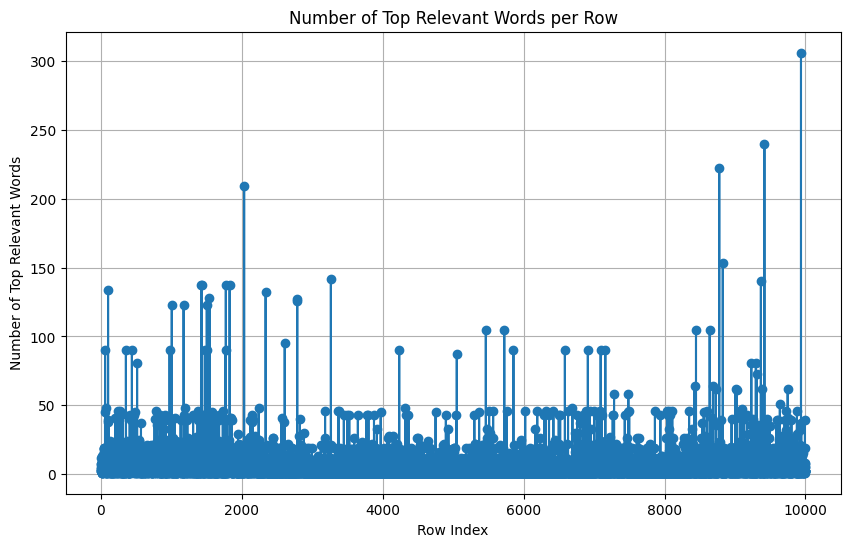

In [172]:
import matplotlib.pyplot as plt

# 각 행에 대해 Top_Relevant_Words 개수를 계산
top_relevant_words_counts = []

for idx, row in tqdm(df3.iterrows(), total=len(df3)):
    top_relevant_words_counts.append(len(row['Top_Relevant_Words']))

# 각 행의 Top_Relevant_Words 개수를 플롯으로 시각화
plt.figure(figsize=(10, 6))
plt.plot(top_relevant_words_counts, marker='o')
plt.xlabel('Row Index')
plt.ylabel('Number of Top Relevant Words')
plt.title('Number of Top Relevant Words per Row')
plt.grid(True)
plt.show()

In [174]:
np.mean(top_relevant_words_counts)

5.2809

In [175]:
min(top_relevant_words_counts)

1

In [176]:
# ID별로 Top_Relevant_Words를 합치는 함수
def merge_top_relevant_words(df):
    result = {}
    for idx, row in df.iterrows():
        if row['ID'] in result:
            result[row['ID']].extend(row['Top_Relevant_Words'])
        else:
            result[row['ID']] = row['Top_Relevant_Words']
    return pd.DataFrame({'ID': list(result.keys()), 'Top_Relevant_Words': list(result.values())})

# 새로운 데이터프레임 df4 생성
df4 = merge_top_relevant_words(df3)


In [177]:
df4

,ID,Top_Relevant_Words
0,1,"[(8705909060, Telegraphy, radiotelegraphy and ..."
1,2,"[(0106141000, Pure-bred breeding animals, 0.93..."
2,3,"[(0106903090, Living Animals, 0.85173982381820..."
3,4,"[(87049010, General motor vehicles for the tra..."
4,5,"[(9605000000, Travel sets for personal toilet,..."
...,...,...
9892,10641,"[(4911990000, Printed, 0.7526559829711914)]"
9893,10642,"[(2202991000, Beverage based on ginseng, 0.880..."
9894,10643,"[(8608002000, Mechanical signalling, safety or..."
9895,10644,"[(73066110, Of iron or non-alloy steel, 0.9289..."


In [178]:
df4['result'] = df4['Top_Relevant_Words'].apply(lambda x: [tup[0] for tup in x])

100%|██████████| 9897/9897 [00:00<00:00, 63038.00it/s]


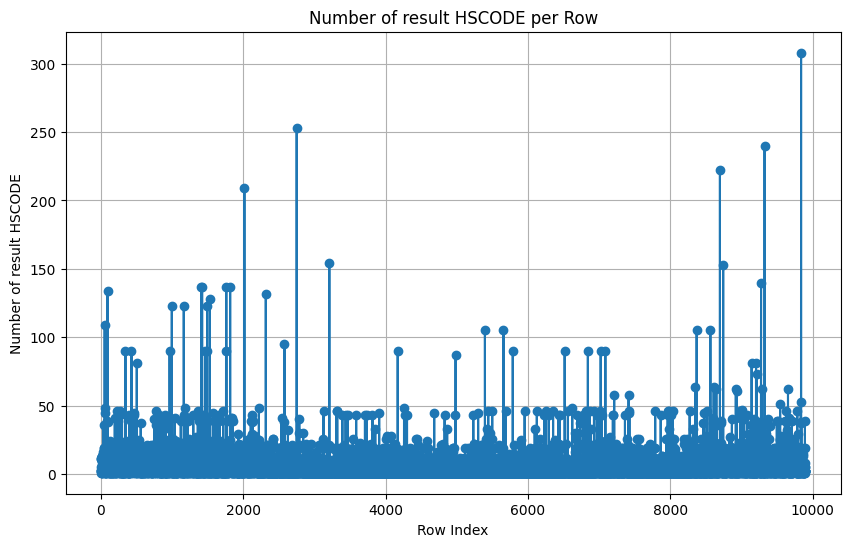

In [182]:
result_hscode_counts = []

for idx, row in tqdm(df4.iterrows(), total=len(df4)):
    result_hscode_counts.append(len(row['result']))

# 각 행의 Top_Relevant_Words 개수를 플롯으로 시각화
plt.figure(figsize=(10, 6))
plt.plot(result_hscode_counts, marker='o')
plt.xlabel('Row Index')
plt.ylabel('Number of result HSCODE')
plt.title('Number of result HSCODE per Row')
plt.grid(True)
plt.show()

In [183]:
np.mean(result_hscode_counts)

5.3358593513185815

In [184]:
min(result_hscode_counts)

1

In [185]:
max(result_hscode_counts)

308

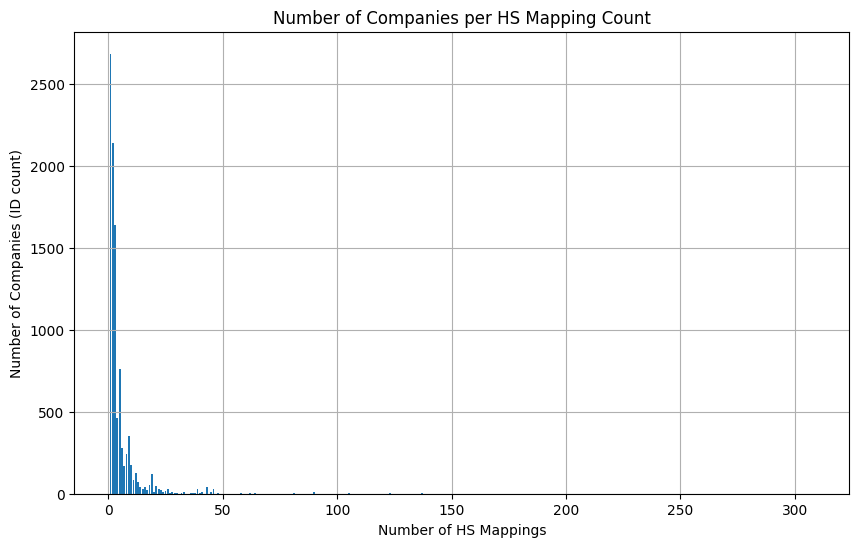

In [186]:
hs_mapping_counts = pd.Series(result_hscode_counts).value_counts().sort_index()

# 각 행의 Top_Relevant_Words 개수를 플롯으로 시각화
plt.figure(figsize=(10, 6))
plt.bar(hs_mapping_counts.index, hs_mapping_counts.values)
plt.xlabel('Number of HS Mappings')
plt.ylabel('Number of Companies (ID count)')
plt.title('Number of Companies per HS Mapping Count')
plt.grid(True)
plt.show()

In [194]:
df4['Top_Relevant_Words'][1]

[('0106141000', 'Pure-bred breeding animals', 0.9341261386871338),
 ('0106195010', 'Pure-bred breeding animals', 0.9341261386871338),
 ('0106196010', 'Pure-bred breeding animals', 0.9341261386871338),
 ('0106149000', 'Living Animals', 0.8035427331924438),
 ('0106209000', 'Living Animals', 0.8035427331924438),
 ('0106195090', 'Living Animals', 0.8035427331924438),
 ('0106196090', 'Living Animals', 0.8035427331924438),
 ('0106199000', 'Living Animals', 0.8035427331924438),
 ('0106490000', 'Living Animals', 0.8035427331924438),
 ('0106202000', 'Fresh-water tortoises', 0.769840657711029),
 ('0106110000', 'Primates', 0.7578986883163452),
 ('0106310000', 'Birds of prey', 0.7538810968399048)]

In [188]:
output_path = '../data/output.csv'
df4.to_csv(output_path, index=False)